In [742]:
import json
import math
import re
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from datetime import datetime, timezone

from multiprocessing.pool import ThreadPool
from urllib import request
from bs4 import BeautifulSoup
from snscrape.modules.twitter import TwitterTweetScraper, TwitterTweetScraperMode

In [672]:
import seaborn as sns
#sns.set_theme()
#sns.reset_orig()
# pd.set_option('display.max_rows', 1000)
# pd.set_option('display.max_colwidth', 200)

In [673]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True

In [2]:
USER_AGENT = 'oryx-scraper/0.0.1'
TIMEOUT = 5
ORYX_URL = 'https://www.oryxspioenkop.com/2022/11/hit-or-miss-russian-loitering-munition.html'
PARALLEL_PROCESSES = 3

In [3]:
headers = {
    'User-Agent': USER_AGENT,
    'Accept-Language': 'en-US,en',
}
req = request.Request(
    url=ORYX_URL,
    headers=headers,
    method='GET',
)
res = request.urlopen(
    req,
    timeout=TIMEOUT,
).read()

In [504]:
soup = BeautifulSoup(res, 'html.parser')
post = soup.find('div', {'class': 'post'}).find('article')
all_links = post.find_all('a', string=re.compile('\(.*\)'))

In [505]:
df = pd.DataFrame(
    data=[(str(l.contents[0]), l.attrs['href']) for l in all_links],
    columns=['text', 'link'],
)
df['date'] = np.nan
df = df.loc[df['link'].str.startswith('https://twitter')]

In [237]:
def extract_twitter_id(url):
    return url.split('://')[-1].split('/status/')[-1].split('/')[-1]

mode = TwitterTweetScraperMode.SINGLE

def extract_date(link):
    tweet_id = extract_twitter_id(link)
    tweet = next(TwitterTweetScraper(
        tweet_id,
        mode=mode
    ).get_items())
    return tweet.date

def process_link(args):
    idx, link = args
    print(f"(Processing {idx}", end='\r')
    # Sleep a bit to not trigger bot alarm
    time.sleep(1.0)
    #amount = len(re.findall('(\d+)[, ]?', elm.text))
    #link = elm.get('href')
    print(link)
    try:
        date = extract_date(link)
    except Exception as e:
        print(e)
        date = None
    return [date, link]
    #for i in range(amount):
    #    yield [date, link]

In [230]:
def dispatch(items):
    print(f"Processing all {len(items)} items...")
    return list(ThreadPool(
        PARALLEL_PROCESSES).imap_unordered(process_link, enumerate(items, 1)))

In [216]:
links = df['link'].values

In [42]:
processed = []

In [196]:
SEGMENTS = 30
# XXX Slow and error prone...
#for seg in range(0, math.ceil(len(links) / SEGMENTS)):
#    processed.extend(dispatch(links[seg*SEGMENTS:(seg+1)*SEGMENTS]))
#    time.sleep(10)

In [506]:
for (date, link) in processed:
    if not date:
        continue
    index = df.loc[df['link'] == link].index
    df.loc[index, 'date'] = date

# Inaccessible tweets?
Apparently `snscrape` marks certain tweets as "tombstones", not accessible
```python
class Tombstone(snscrape.base.Item):
	'''A placeholder for a tweet that cannot be accessed'''
```

In [ ]:
todo = []
for (date, link) in processed:
    if not date:
        todo.append(link)
todo = list(set(todo))

In [267]:
#from IPython.display import display, HTML
#for link in todo:
#    display(HTML(f'<a href="{link}">{link}</a>'))

In [266]:
manually = {
    'https://postlmg.cc/WFbTVcZB': '2023-02-27',
    # 'https://twitter.com/mdfzeh/': (withheld),
    # 'https://postlmg.cc/0rsDvMMD': (no date visible),
    'https://postimg.cc/Sjk4ZLnp': '2023-03-23',
    'https://postlmg.cc/mhSsXJWC': '2022-02-27',
    'https://twitter.com/BarracudaVol1/status/1610624751701032961': '2023-01-04',
    # 'https://postlmg.cc/HrWs9MZ0': (no date visible),
    # 'https://postlmg.cc/rdLqhY9r': (no date visible),
    'https://postimg.cc/jDYKPDgR': '2022-12-01',
    'https://postlmg.cc/XpJ112MJ': '2022-02-28',
    'https://postimg.cc/jWT6fTbQ': '2022-11-06',
    'https://twitter.com/RALee85/status/1607525854296567808': '2022-12-27',
    # 'https://twitter.com/mdfzeh/status/1591439680247136256': (withheld),
    'https://postimg.cc/w783M3r9': '2023-03-28',
    'https://postlmg.cc/jDxD5myh': '2022-02-27',
    'https://postimg.cc/9R6yWHJ7': '2022-11-06',
    # 'https://twitter.com/DrazaM33/status/1597864976492171265': (deleted),
    # 'https://postlmg.cc/rd90Fgt4': (no date visible),
    # 'https://postlmg.cc/tsMQDpM1': (no date visible),
    'https://postlmg.cc/V5c2ZwLh': '2023-03-05',
    # 'https://postlmg.cc/XBXtvVQC': (no date visible),
}

In [507]:
for (link, date) in manually.items():
    index = df.loc[df['link'] == link].index
    df.loc[index, 'date'] = pd.to_datetime(date, utc=True)

In [508]:
df = df.set_index('date')

In [509]:
df = df[df.index.notnull()]

In [510]:
df.index = df.index.normalize()
df = df.sort_index()

In [511]:
def get_weapon(text):
    return re.findall('by ([a-zA-Z0-9 -]+)\)', text)[0]

In [512]:
def get_amount(text):
    return int(re.findall('(\d+)[, ]?', text)[0])

In [513]:
df['weapon'] = df['text'].apply(get_weapon)

In [514]:
df['amount'] = df['text'].apply(get_amount)

In [ ]:
df.to_pickle('loitering.pickle')

In [ ]:
df.reset_index().to_json('loitering.json')

# Analysis

In [515]:
df['weapon'].value_counts()

Lancet-3M                     111
Kub                             5
Lancet-3                        5
unknown loitering munition      1
Name: weapon, dtype: int64

<AxesSubplot: xlabel='date'>

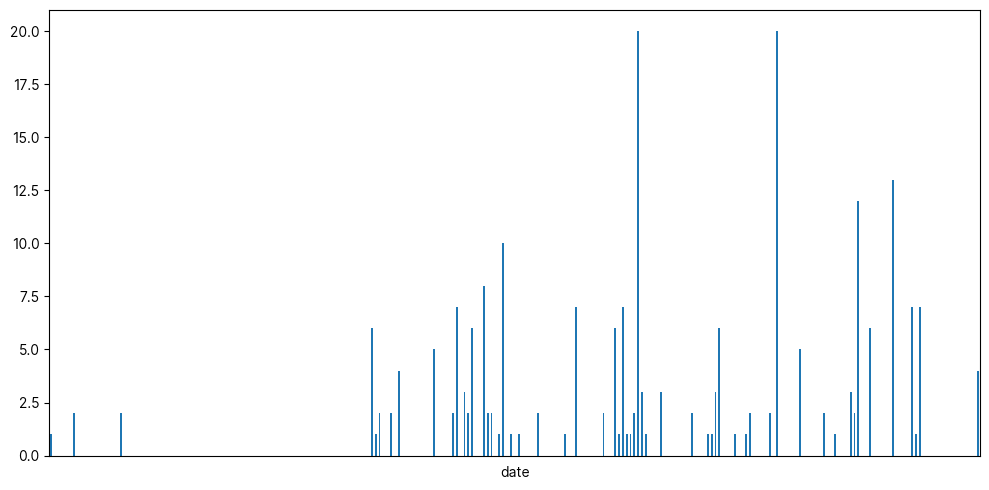

In [516]:
df.loc[df['weapon'] == 'Lancet-3M', 'amount'].resample('1d').sum().plot.bar(xticks=[])

<AxesSubplot: xlabel='date'>

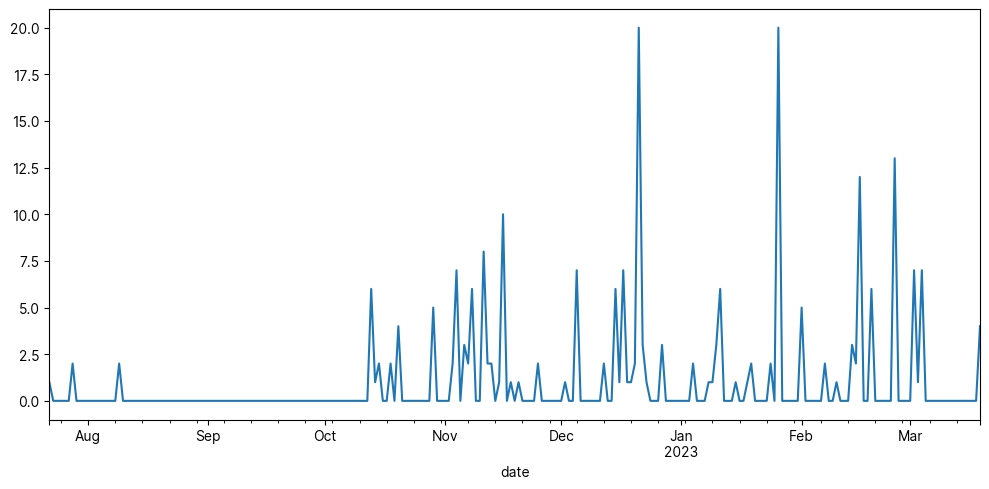

In [341]:
df.loc[df['weapon'] == 'Lancet-3M', 'amount'].resample('1d').sum().plot.line()

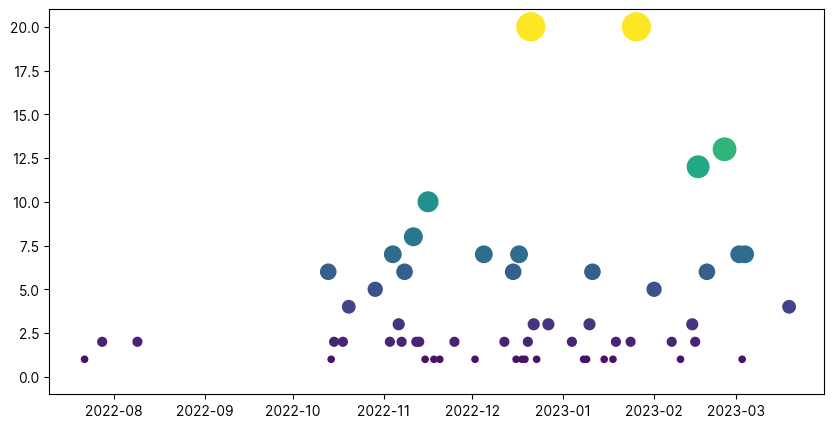

In [533]:
plt.figure()
plt.scatter(
    x=df.loc[df['weapon'] == 'Lancet-3M', 'amount'].resample('1d').sum().index,
    y=df.loc[df['weapon'] == 'Lancet-3M', 'amount'].resample('1d').sum(),
    s=df.loc[df['weapon'] == 'Lancet-3M', 'amount'].resample('1d').sum() * 20,
    c=df.loc[df['weapon'] == 'Lancet-3M', 'amount'].resample('1d').sum(),
)
plt.show()

In [376]:
def plot_bar_date(min_, max_, values, freq, width=0.5):
    datelist = pd.date_range(
        start=min_,
        end=max_,
        freq=freq,
    )
    ax = plt.bar(
        datelist,
        values,
        width=width
    )
    # ax.xaxis.set_major_locator(mdates.YearLocator())
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

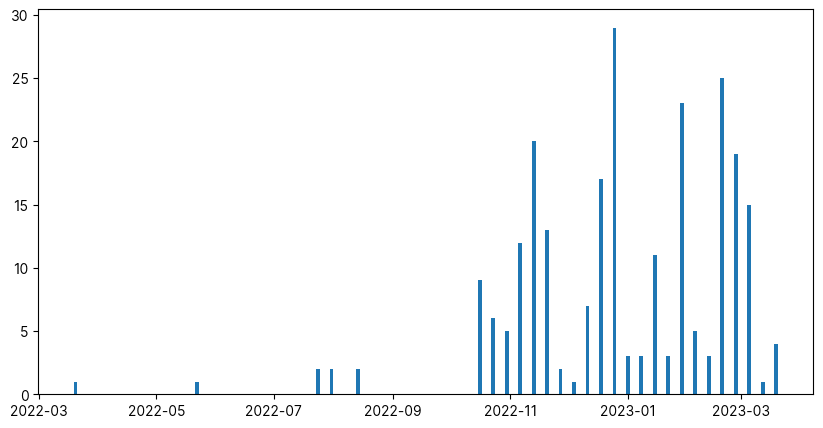

In [532]:
FREQ = '1w'
plot_bar_date(
    df.index.min(),
    df.index.max(),
    df['amount'].resample(FREQ).sum()[:-1],
    FREQ,
    width=2
)

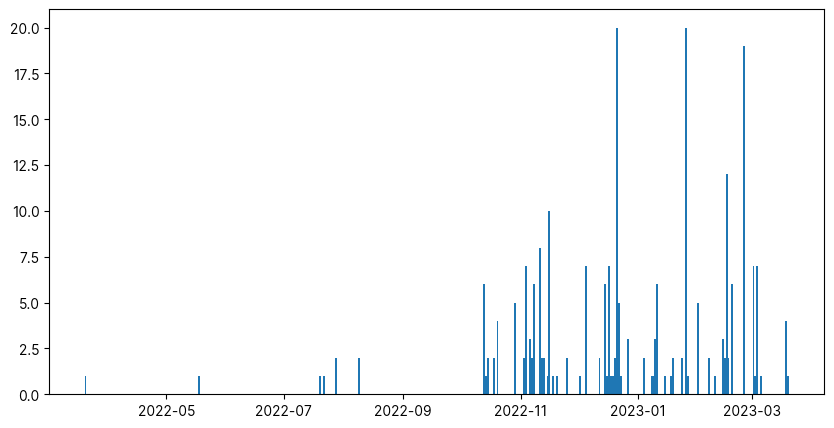

In [531]:
FREQ = '1d'
plot_bar_date(
    df.index.min(),
    df.index.max(),
    df['amount'].resample(FREQ).sum(),
    FREQ,
    width=1,
)

In [746]:
lancet = pd.read_csv('lancet.csv', parse_dates=True)
lancet['date'] = pd.to_datetime(lancet['Дата публикации'], utc=True)

In [747]:
lancet = lancet.set_index('date').sort_index()

In [748]:
lancet['amount'] = 1

In [754]:
# Dummy values to allow shared axis scale
_common_start = datetime(2022, 2, 20, 0, 0, tzinfo=timezone.utc)
lancet.loc[_common_start, 'amount'] = 0
df.loc[_common_start, 'amount'] = 0

<AxesSubplot: xlabel='Дата публикации'>

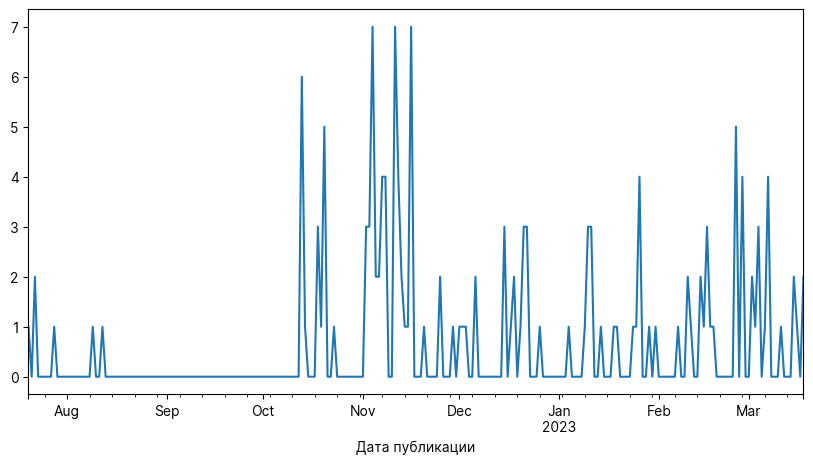

In [555]:
lancet['Источник'].resample('1d').count().plot()

Locator attempting to generate 2776 ticks ([5.0, ..., 19430.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2776 ticks ([5.0, ..., 19430.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2776 ticks ([5.0, ..., 19430.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2776 ticks ([5.0, ..., 19430.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2776 ticks ([5.0, ..., 19430.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2776 ticks ([5.0, ..., 19430.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2776 ticks ([5.0, ..., 19430.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2776 ticks ([5.0, ..., 19430.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2776 ticks ([5.0, ..., 19430.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2776 ticks ([5.0, ..., 19430.0]),

Locator attempting to generate 2776 ticks ([5.0, ..., 19430.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2776 ticks ([5.0, ..., 19430.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2776 ticks ([5.0, ..., 19430.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2776 ticks ([5.0, ..., 19430.0]), which exceeds Locator.MAXTICKS (1000).


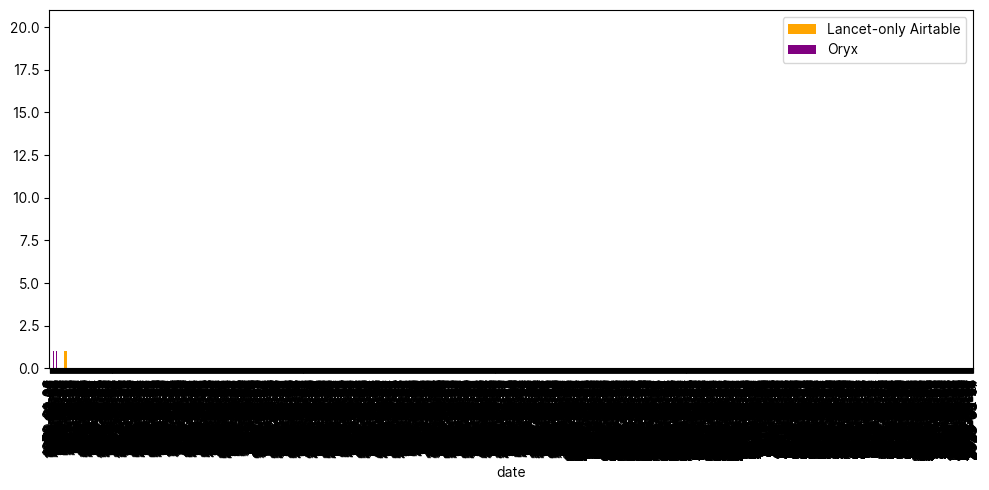

In [809]:
_freq = '1d'
fig, ax = plt.subplots(1, 1, sharex=True)

lancet['Источник'].resample(_freq).count().plot(kind='bar', color='orange', ax=ax, position=-0.5)
df['amount'].resample(_freq).sum().plot(kind='bar', color='purple', ax=ax, position=0.5)

datelist = pd.date_range(
    start=df['amount'].resample(_freq).sum().index.min(),
    end=df['amount'].resample(_freq).sum().index.max(),
    freq=_freq,
)
ax.set_xticks(datelist.date)
#ax.set_xticklabels(datelist)
#ax.set_xticks(df['amount'].resample(_freq).sum().index.date)
#ax.set_xticklabels(df['amount'].resample(_index_freq).sum().index.date)
ax.tick_params(axis="x", rotation=65)

# specify the position of the major ticks at the beginning of the week
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday = 1))
# specify the format of the labels as 'year-month-day'
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# (optional) rotate by 90° the labels in order to improve their spacing
plt.setp(ax.xaxis.get_majorticklabels(), rotation = 90)

plt.legend(['Lancet-only Airtable', 'Oryx'])
_name = 'oryx-lancet-comparison-daily'
plt.savefig(f'{_name}.svg')
plt.savefig(f'{_name}.png')
#ax.set_xticklabels([])

In [808]:
datelist

DatetimeIndex(['2022-02-20 00:00:00+00:00', '2022-02-21 00:00:00+00:00',
               '2022-02-22 00:00:00+00:00', '2022-02-23 00:00:00+00:00',
               '2022-02-24 00:00:00+00:00', '2022-02-25 00:00:00+00:00',
               '2022-02-26 00:00:00+00:00', '2022-02-27 00:00:00+00:00',
               '2022-02-28 00:00:00+00:00', '2022-03-01 00:00:00+00:00',
               ...
               '2023-03-11 00:00:00+00:00', '2023-03-12 00:00:00+00:00',
               '2023-03-13 00:00:00+00:00', '2023-03-14 00:00:00+00:00',
               '2023-03-15 00:00:00+00:00', '2023-03-16 00:00:00+00:00',
               '2023-03-17 00:00:00+00:00', '2023-03-18 00:00:00+00:00',
               '2023-03-19 00:00:00+00:00', '2023-03-20 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=394, freq='D')

In [585]:
#sns.lineplot(data=df, x=df.index, y='amount', hue='weapon')

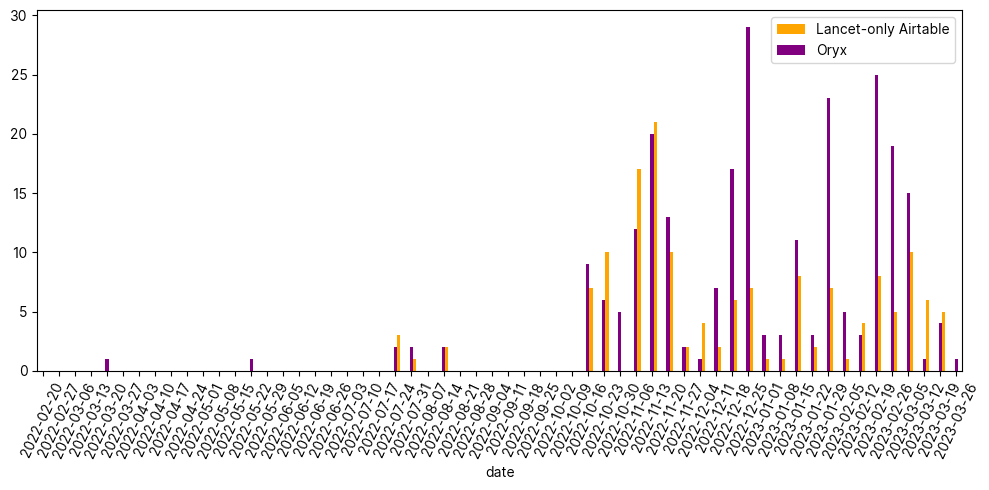

In [775]:
_freq = '1w'
fig = plt.figure()
ax = fig.add_subplot(111)
lancet['Источник'].resample(_freq).count().plot(kind='bar', ax=ax, position=-0.5, color='orange', width=0.2)
df['amount'].resample(_freq).sum().plot(kind='bar', ax=ax, position=0.5, color='purple', width=0.2)

ax.set_xticklabels(df['amount'].resample(_freq).sum().index.date)
ax.tick_params(axis="x", rotation=65)
#ax.set_xticks([])

plt.legend(['Lancet-only Airtable', 'Oryx'])
_name = 'oryx-lancet-comparison-weekly'
plt.savefig(f'{_name}.svg')
plt.savefig(f'{_name}.png')
#ax.set_xticklabels([])

In [677]:
_freq = '1d'
combined = pd.DataFrame(pd.concat(
    {
        'oryx': df['amount'].resample(_freq).sum(), # .groupby(by='date').sum(),
        'lancet': lancet['amount'].resample(_freq).sum(), # .groupby(by='date').sum()
    }, axis=0, ignore_index=False,
    sort=False,
)).reset_index(names=['source', 'date'])

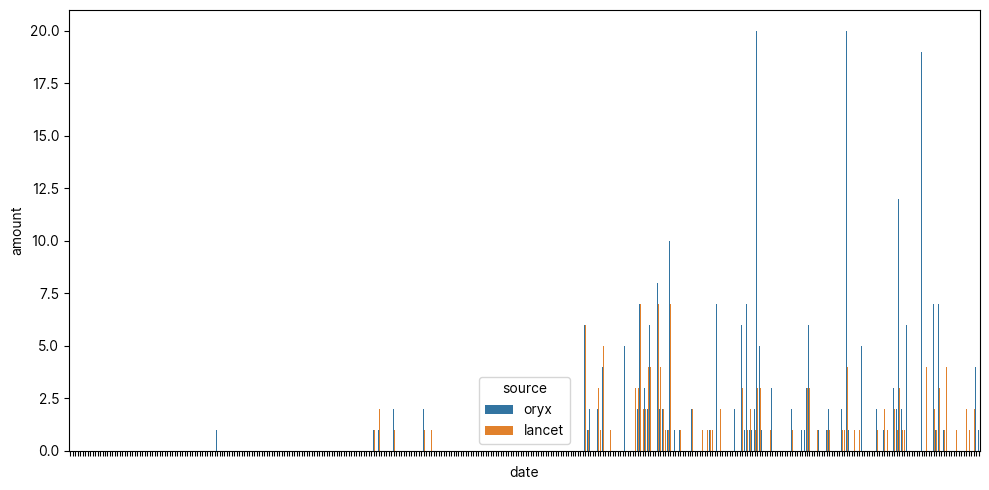

In [771]:
#datelist = pd.date_range(
#    start=combined.index.min(),
#    end=combined.index.max(),
#    freq=_freq,
#)

ax = sns.barplot(data=combined, x='date', y='amount', hue='source')
ax.set_xticklabels([])
plt.show()

#ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday = 1))
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#plt.setp(ax.xaxis.get_majorticklabels(), rotation = 90)
#ax.xaxis.set_minor_locator(mdates.DayLocator(interval = 1))

<AxesSubplot: xlabel='date'>

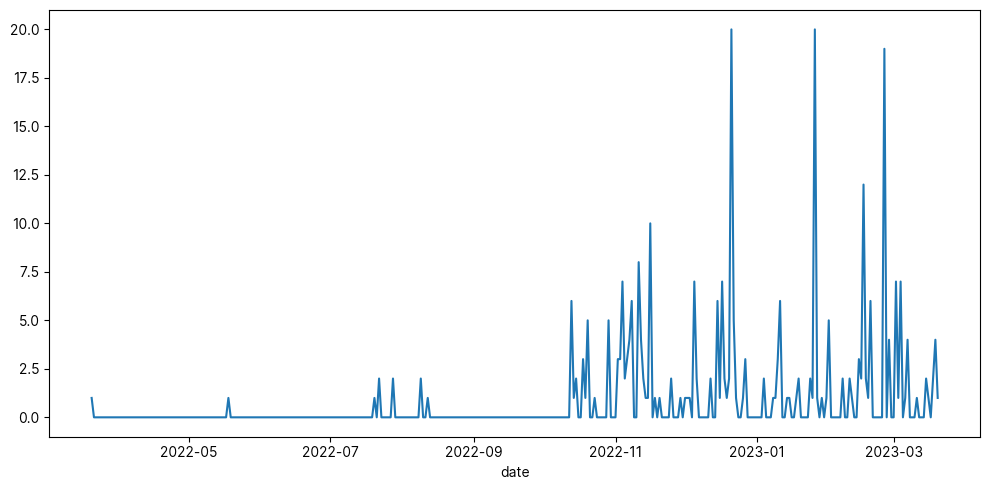

In [772]:
combined['amount'].groupby(combined['date'].dt.date).max().plot()

<AxesSubplot: xlabel='y(t)', ylabel='y(t + 1)'>

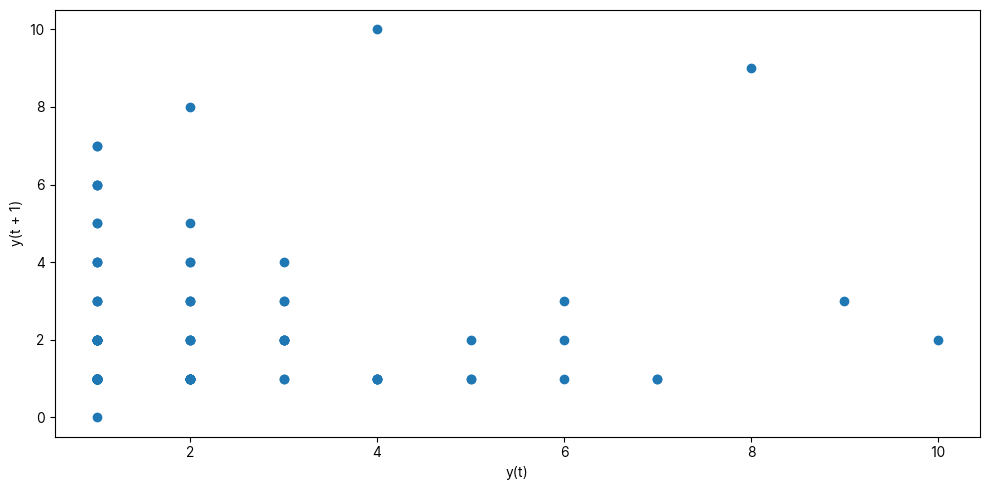

In [773]:
pd.plotting.lag_plot(df['amount'])

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

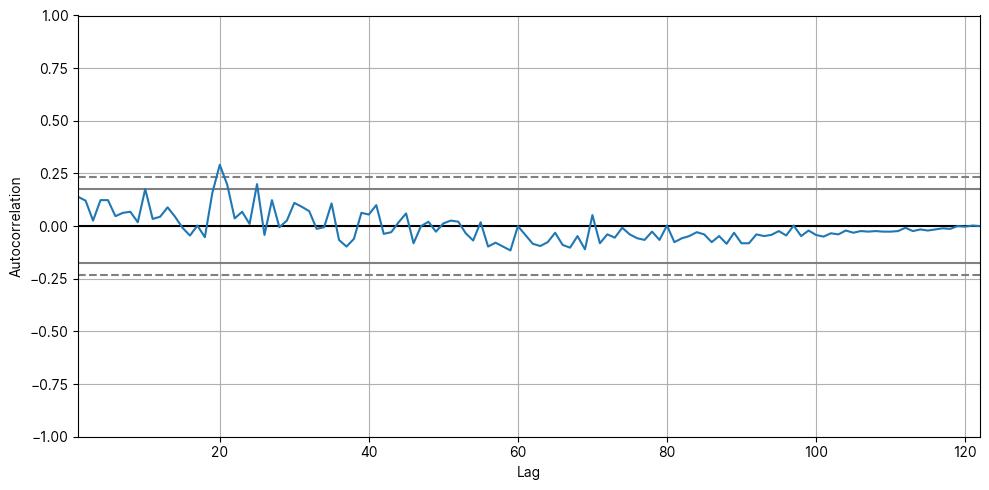

In [724]:
pd.plotting.autocorrelation_plot(df['amount'])